# Machine Learning Model Productionization

In [3]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.metrics as metrics

<h2 id="load_dataset">Load the Cancer data</h2>
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)(http://mlearn.ics.uci.edu/MLRepository.html). The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

<br>
<br>


## Load Data From CSV File


In [1]:
import os
os.chdir(r"D:\Ritwik's Download\Data Analysis")

In [12]:
df = pd.read_csv("cell_samples.csv")
df

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:


In [6]:
# change benign as 1 and malignant as 2
def replace_values(x):
    if x == 2:
        return 1
    elif x == 4:
        return 2
    else:
        return x
        
        
df['Class'] = df['Class'].apply(replace_values)

In [7]:
df

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,1
1,1002945,5,4,4,5,7,10,3,2,1,1
2,1015425,3,1,1,1,2,2,3,1,1,1
3,1016277,6,8,8,1,3,4,3,7,1,1
4,1017023,4,1,1,3,2,1,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,1
695,841769,2,1,1,1,2,1,1,1,1,1
696,888820,5,10,10,3,7,3,8,10,2,2
697,897471,4,8,6,4,3,4,10,6,1,2


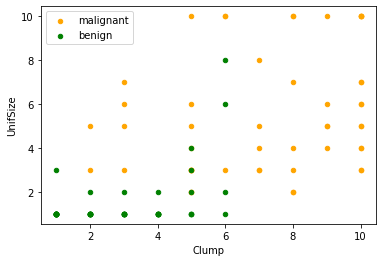

In [11]:
ax = df[df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='orange', label='malignant')
df[df['Class'] == 1][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='green', label='benign', ax=ax)
plt.show()

## Data pre-processing and selection


Let's first look at columns data types:


In [13]:
df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the **BareNuc** column includes some values that are not numerical. We can drop those rows:


In [16]:
df = df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')
df.dtypes

C:\Users\RITWIK~1\AppData\Local\Temp/ipykernel_15236/1673382673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BareNuc'] = df['BareNuc'].astype('int')


ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [17]:
feature_df = df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = feature_df

We want the model to predict the value of Class (that is, benign (=1) or malignant (=2)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.


In [19]:
df['Class'] = df['Class'].astype('int')
y = df['Class']

C:\Users\RITWIK~1\AppData\Local\Temp/ipykernel_15236/138505466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Class'] = df['Class'].astype('int')


## Train/Test dataset


We split our dataset into train and test set:


In [20]:
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


In [21]:
x_train

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
482,9,10,10,10,10,5,10,10,10
94,2,1,1,1,2,1,3,1,1
526,4,1,1,1,2,1,1,1,1
316,5,5,5,2,5,10,4,3,1
333,5,4,6,6,4,10,4,3,1
...,...,...,...,...,...,...,...,...,...
614,2,1,1,1,1,1,2,1,1
374,3,1,2,1,2,1,2,1,1
454,2,3,1,1,3,1,1,1,1
180,1,1,1,1,1,1,3,1,1


### Standardisation of samples

In [28]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(x_train)
x_train_scale = pd.DataFrame(data, index = x_train.index, columns=x_train.columns)
x_train_scale
data

array([[ 1.64275   ,  2.26468364,  2.31646537, ...,  2.7425329 ,
         2.27676132,  4.762086  ],
       [-0.87170355, -0.69270552, -0.72877562, ..., -0.16831429,
        -0.61494329, -0.34393421],
       [-0.15328825, -0.69270552, -0.72877562, ..., -0.99998492,
        -0.61494329, -0.34393421],
       ...,
       [-0.87170355, -0.03550793, -0.72877562, ..., -0.99998492,
        -0.61494329, -0.34393421],
       [-1.2309112 , -0.69270552, -0.72877562, ..., -0.16831429,
        -0.61494329, -0.34393421],
       [ 0.2059194 ,  0.29309087,  0.96302493, ...,  1.91086227,
         2.27676132, -0.34393421]])

In [25]:
x_test_scale = pd.DataFrame(scale.transform(x_test), columns=x_test.columns, index = x_test.index)
x_test_scale

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
693,-0.512496,-0.692706,-0.728776,-0.639706,-0.557528,-0.689260,-0.584150,-0.614943,0.223401
669,0.205919,2.264684,2.316465,1.759662,0.779560,0.414364,1.495027,2.276761,-0.343934
545,0.205919,-0.692706,-0.728776,-0.639706,-0.557528,-0.689260,-0.584150,-0.614943,-0.343934
106,2.001958,2.264684,2.316465,1.759662,-0.557528,1.793894,0.247521,-0.614943,-0.343934
185,-0.871704,-0.692706,-0.728776,-0.639706,-1.003224,-0.689260,-0.168314,-0.614943,-0.343934
...,...,...,...,...,...,...,...,...,...
77,0.205919,-0.035508,-0.728776,-0.296939,-0.557528,-0.689260,-0.584150,-0.614943,-0.343934
277,-1.230911,-0.692706,-0.728776,-0.639706,-0.557528,-0.689260,-0.584150,-0.614943,-0.343934
417,-1.230911,-0.692706,-0.728776,-0.639706,-0.557528,-0.689260,-0.584150,-0.614943,-0.343934
165,-0.153288,-0.692706,-0.728776,-0.639706,-0.557528,-0.413354,-0.168314,-0.293643,-0.343934


In [45]:
x_train_scale = np.asarray(x_train_scale)
x_train_scale[0:5]

array([[ 1.64275   ,  2.26468364,  2.31646537,  2.44519553,  3.00803899,
         0.41436428,  2.7425329 ,  2.27676132,  4.762086  ],
       [-0.87170355, -0.69270552, -0.72877562, -0.63970584, -0.55752799,
        -0.6892596 , -0.16831429, -0.61494329, -0.34393421],
       [-0.15328825, -0.69270552, -0.72877562, -0.63970584, -0.55752799,
        -0.6892596 , -0.99998492, -0.61494329, -0.34393421],
       [ 0.2059194 ,  0.62168966,  0.62466482, -0.29693902,  0.77955963,
         1.79389413,  0.24752102,  0.02765774, -0.34393421],
       [ 0.2059194 ,  0.29309087,  0.96302493,  1.07412825,  0.33386376,
         1.79389413,  0.24752102,  0.02765774, -0.34393421]])

In [47]:
x_test_scale = np.asarray(x_test_scale)
x_test_scale

array([[-0.5124959 , -0.69270552, -0.72877562, ..., -0.58414961,
        -0.61494329,  0.22340137],
       [ 0.2059194 ,  2.26468364,  2.31646537, ...,  1.49502696,
         2.27676132, -0.34393421],
       [ 0.2059194 , -0.69270552, -0.72877562, ..., -0.58414961,
        -0.61494329, -0.34393421],
       ...,
       [-1.2309112 , -0.69270552, -0.72877562, ..., -0.58414961,
        -0.61494329, -0.34393421],
       [-0.15328825, -0.69270552, -0.72877562, ..., -0.16831429,
        -0.29364278, -0.34393421],
       [ 2.00195765,  2.26468364,  2.31646537, ...,  0.66335633,
         0.02765774,  0.79073695]])

### To get the value of mean and variance of each columns

In [51]:
scale.scale_,scale.var_ 

(array([2.78390508, 3.04322479, 2.95543112, 2.91743525, 2.24368244,
        3.6244232 , 2.40479817, 3.11235109, 1.76262522]),
 array([ 7.75012747,  9.26121711,  8.73457312,  8.51142844,  5.03411088,
        13.13644353,  5.78305425,  9.68672933,  3.10684767]))

## Model Development 

<h3 id="modeling">1) Modeling (SVM with Scikit-learn)</h3>


The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.


In [48]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(x_train_scale, y_train) 

SVC()

After being fitted, the model can then be used to predict new values:


In [60]:
yhat = clf.predict(x_test_scale)
yhat [0:5]

array([2, 4, 2, 4, 2])

In [61]:
svm_acc_Score = metrics.accuracy_score(yhat, y_test)
svm_acc_Score

0.9635036496350365

In [53]:
SVM_JaccardIndex = metrics.jaccard_score(yhat, y_test, average='weighted')
SVM_JaccardIndex

0.9290348742903487

In [56]:
SVM_F1_Score = metrics.f1_score(yhat, y_test, pos_label=2)
SVM_F1_Score

0.9714285714285714

<h3 id="modeling">2) Modeling (Logistic Regression with Scikit-learn)</h3>

Let's build our model using **LogisticRegression** from the Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. You can find extensive information about the pros and cons of these optimizers if you search it in the internet.

The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem of machine learning models.
**C** parameter indicates **inverse of regularization strength** which must be a positive float. Smaller values specify stronger regularization.
Now let's fit our model with train set:


In [119]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train_scale,y_train)

In [120]:
yhat = LR.predict(x_test_scale)

In [121]:
lr_acc_score = metrics.accuracy_score(yhat, y_test)
lr_acc_score

0.9708029197080292

In [122]:
lr_JaccardIndex = metrics.jaccard_score(yhat, y_test, average='weighted')
lr_JaccardIndex

0.9429034874290348

In [123]:
lr_F1_Score = metrics.f1_score(yhat, y_test, pos_label=2)
lr_F1_Score

0.9772727272727273

In [124]:
Lr_logloss = metrics.log_loss(yhat, y_test)
Lr_logloss

21.68177763022858

<h3 id="modeling">3) Modeling (Decision Tree with Scikit-learn)</h3>
    



We will first create an instance of the <b>DecisionTreeClassifier</b> called <b>drugTree</b>.<br>
    Inside of the classifier, specify <i> criterion="entropy" </i> so we can see the information gain of each node.

In [105]:
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(x_train_scale, y_train)
Tree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [106]:
yhat = Tree.predict(x_test_scale)

In [107]:
tree_acc_score = metrics.accuracy_score(yhat, y_test)
tree_acc_score

0.9708029197080292

In [108]:
tree_JaccardIndex = metrics.jaccard_score(yhat, y_test, average='weighted')
tree_JaccardIndex

0.9434322761157781

In [109]:
tree_F1_Score = metrics.f1_score(yhat, y_test, pos_label=2)
tree_F1_Score

0.9777777777777777

<h3 id="modeling">4) Modeling (KNN with Scikit-learn)</h3>
    



**K-Nearest Neighbors** is a supervised learning algorithm. Where the data is 'trained' with data points corresponding to their classification. To predict the class of a given data point, it takes into account the classes of the 'K' nearest data points and chooses the class in which the majority of the 'K' nearest data points belong to as the predicted class.


In [29]:
KNN = KNeighborsClassifier(n_neighbors = 4).fit(x_train_scale,y_train)

In [30]:
yhat = KNN.predict(x_test_scale)

In [31]:
knn_acc_score = metrics.accuracy_score(yhat, y_test)
knn_acc_score

0.9781021897810219

In [32]:
knn_jcc_idx = metrics.jaccard_score(yhat, y_test, pos_label=2)
knn_jcc_idx

0.9666666666666667

In [33]:
knn_F1_Score = metrics.f1_score(yhat, y_test, pos_label=2)
knn_F1_Score

0.983050847457627

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, yhat)
print(classification_report(yhat, y_test))

              precision    recall  f1-score   support

           2       0.97      1.00      0.98        87
           4       1.00      0.94      0.97        50

    accuracy                           0.98       137
   macro avg       0.98      0.97      0.98       137
weighted avg       0.98      0.98      0.98       137



<h2 id="evaluation">Evaluation</h2>


In [115]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [125]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137

Confusion matrix, without normalization
[[ 0  0]
 [ 0 86]]


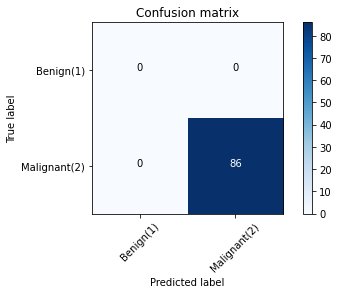

In [126]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(1)','Malignant(2)'],normalize= False,  title='Confusion matrix')

You can also easily use the **f1\_score** from sklearn library:


In [127]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9710669934861801

Let's try the jaccard index for accuracy:


In [128]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=2)

0.9555555555555556

### Reporting 

In [129]:
ml=pd.DataFrame()

In [139]:
clas = ["knn", "des Tree", "Log reg", "SVM"]
acc = [knn_acc_score, tree_acc_score, lr_acc_score, svm_acc_Score]
jac = [knn_jcc_idx, tree_JaccardIndex, lr_JaccardIndex, SVM_JaccardIndex]
fsco = [knn_F1_Score, tree_F1_Score, lr_F1_Score, SVM_F1_Score]
log = ["no", "no", Lr_logloss, "no"]
ml["Classifier"] = clas
ml["accuracy Score"] = acc
ml["Jaccard Index"] = jac
ml["f1-score"] = fsco
ml["log loss"] = log
ml

,Classifier,accuracy Score,Jaccard Index,f1-score,log loss
0,knn,0.978102,0.966667,0.983051,no
1,des Tree,0.970803,0.943432,0.977778,no
2,Log reg,0.970803,0.942903,0.977273,21.681778
3,SVM,0.963504,0.942903,0.971429,no


### Input of user

In [141]:
feature_df.columns

Index(['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc',
       'BlandChrom', 'NormNucl', 'Mit'],
      dtype='object')

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

In [ ]:
print("Enter the cell type Details")
clump = int(input('Clump thickness: '))
c_size = int(input('Enter the cell size : '))
c_shape = int(input('Enter the cell shape : '))
mar_ad = inat(input('Enter Marginal adhesion : '))
sin_eph_cell = float(input('Enter Single epithelial cell size : '))
fbs = float(input('Enter the fbs : '))
restecg = float(input('Enter the restecg : '))
thalach = float(input('Enter the thalach : '))
exang = float(input('Enter the exang : '))
oldpeak = float(input('Enter the oldpeak : '))
slope = float(input('Enter the slope : '))
ca = float(input('Enter the ca : '))
thal = float(input('Enter the thal : '))